In [1]:
# Initialization

import math
from datetime import datetime
import openpyxl as opxl
from openpyxl.utils.dataframe import dataframe_to_rows
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import model as ty
import proc as pr
import matplotlib.ticker as mtick
import sklearn.metrics

from IPython.core.display import HTML

import heat_transfer as bht

import fluids as fds
import ht 

import general as gen

import os

import scipy.integrate as integrate
import scipy.optimize as sco

import networkx as nx

import plotly.graph_objects as go

import plot_functions_here as pfun

In [2]:
input_name = r'\Inputs_TEST.xlsx'
hyp_name = '\Model_hypotheses.xlsx'
data = r'\221122_TUV_test_conditions_S425-I_MPP.xlsx'

output_name = 'TEST_n1'

par = pr.import_input(r'G:\Drive partagés\BU04-Innovation\PVT-perf-1Dmodel\Inputs',input_name)
hyp = pr.create_dict_from_excel(r'G:\Drive partagés\BU04-Innovation\PVT-perf-1Dmodel\Hypotheses',hyp_name,'Main')
condi = pr.create_inputs_from_excel(r'G:\Drive partagés\BU04-Innovation\PVT-perf-1Dmodel\Steady-state conditions inputs'+data,par,hyp)

{'exchanger': {'name': nan, 'eta_nom': 0.201, 'Eff_T': -0.0034000000000000002, 'T_ref': 298.15, 'Eff_G': 0, 'G_ref': 1000, 'X_corr': 1, 'tau_g': 0.8, 'alpha_g': 0.05, 'eps_PV': 0.9, 'eps_g': 0.9, 'eps_bs': 1, 'w_pan': 0.1, 'L_pan': 0.1, 'orientation': 'portrait', 'lambd_upper_glass': 0.002, 'lambd_upper_EVA': 0.000515, 'lambd_si': 0.00015, 'lambd_lower_EVA': 0.000515, 'lambd_PVDF': 0.0, 'lambd_PET': 0.0, 'lambd_adh': 0.0, 'lambd_lower_glass': 0.002, 'k_glass': 0.8, 'k_EVA': 0.24, 'k_si': 60, 'k_PVDF': 0.2, 'k_PET': 0.3, 'k_adh': 0.2, 'L_abs': 1.0, 'w_abs': 0.1, 'geometry': 'harp', 'N_harp': 1, 'N_meander': 1, 'L_tube': 1.0, 'tube_geometry': 'circular', 'H_tube': 0.01, 'w_tube': 0.01, 'W': 0.1, 'l_c': 0.01, 'p_ext_tube': 0.06283185307179587, 'p_ext_tube_rad': 0.06283185307179587, 'p_tube_sky': 0.01, 'lambd_air': 0.0, 'lambd_conductive_plate': 0.0, 'lambd_abs': 0.001, 'lambd_riser_plate': 0.002, 'lambd_riser_back': 0.002, 'lambd_ins': 0.0, 'eps_hx_top': 0, 'eps_hx_back': 0.8, 'eps_ins': 

In [3]:
par_p = ty.write_par_p_from_condi(condi,0,hyp)

In [4]:
slices_df,df_one,its_df_list = ty.simu_one_steady_state(par['exchanger'],par_p,hyp)

top h simple theta<=45 Ra_L 30675.58237287449
top h simple theta<=45 Ra_L 117758.34660160351
top h simple theta<=45 Ra_L 110465.521375885
top h simple theta<=45 Ra_L 110617.97542567657


c:\Users\valen\Dropbox (DualSun)\PC\Documents\GitHub\PVT-thermal-performance-model\heat_transfer.py:291: RuntimeWarning: divide by zero encountered in scalar divide
  x_c = (nu*Re_c)/speed


In [5]:
df_one['h_back']

0    2.333368
Name: h_back, dtype: float64

In [6]:
pr.disp_html(its_df_list[0])

,G,Gp,T_amb,T_sky,T_back,T_back_rad,u,mdot,T_fluid_in,Slice,T_PV0,Cp,h_rad_f,h_top_g,h_back,h_rad_back,h_back_tube,h_rad_tube_sky,h_rad_back_tube,h_back_fins,T_PV,T_fluid_out,T_tube_mean,T_glass,Re,Nu,h_fluid,gamma_0_int,gamma_1_int,gamma_2_int,h_rad_g,h_rad,a0,a1,a3,a2,X_celltemp,eta_PV,S,S_star,Fp,j,m,b,e0,e1,e2,e3,e4,f0,b1,b2,b3,b4,Ka_Bt,Th_Bt,Ep_Bt,d1,d2,d3,d4,Ka_tf,Th_tf,Ep_tf,a_f,b_f,q_tube_fluid,T_fluid_mean,T_Base_mean,T_absfin_mean,T_abs_mean,Qdot_tube_back,Qdot_absfin_back,T_ins_tube_mean,T_ins_absfin_mean,T_ins_mean,Qdot_ins_conv,Qdot_ins_rad,T_PV_Base_mean,T_PV_absfin_mean,qp_PV_Base,qp_Base_back,qp_fin,Qdot_top_conv,Qdot_top_rad,Qdot_sun_glass,Qdot_sun_PV,Qdot_glass_PV,Qdot_PV_sky,Qdot_PV_plate,Qdot_PV_Base,Qdot_PV_absfin,Qdot_Base_back,Qdot_tube_fluid,Qdot_tube_sky,Qdot_Base_tube,Qdot_absfin_Base,Qdot_abs_back2,Qdot_fluid_back,Qdot_absfin_back_conv,Qdot_absfin_back_rad,Qdot_tube_back_conv,Qdot_tube_back_rad,Qdot_ins_tube_back_conv,Qdot_ins_tube_back_rad,Qdot_ins_absfin_back_conv,Qdot_ins_absfin_back_rad,Qdot_f01,power_balance_1,power_balance_3,T_B_check
0,1001.0,4,281.15,281.15,281.15,281.15,0.3,0.0478,288.15,0,284.650000,3690.775238,0.0,12.980620,2.383016,4.333938,2.383016,0.0,4.311802,2.383016,296.374951,288.300662,293.763180,295.853045,1114.146107,4.363636,173.280145,0,0,0,4.621997,4.621692,11.970772,0.957848,16.860639,-4788.308847,1.045900,0.210226,632.451099,6720.234519,0.909128,22.582285,9.660180,7029.486777,739.106249,0.992189,0.007365,0.000425,0.00002,733.662493,0.185143,1.000449,-0.000428,-0.00002,-1.935672,0.358215,602.817463,-0.311705,-0.002314,0.314026,-0.000006,-2.249831,1.415925,691.143341,-0.007941,2.439500,30.146155,288.225431,293.809950,294.833313,294.730977,5.305707,8.271917,293.763180,294.833313,294.726300,6.788150,6.788150,295.537619,296.467988,5.512718,0.0,15.197402,19.085464,6.795744,5.005,63.245110,-20.876208,7.036504,35.332399,3.713118,31.619293,0.0,30.146155,0.0,34.297900,30.394804,-1.224476,2.762780,2.934680,5.337237,1.888563,3.417144,1.888563,3.417144,2.934680,5.337237,0.0,2.031504,1.198987,293.809950
1,1001.0,4,281.15,281.15,281.15,281.15,0.3,0.0478,288.15,0,296.374951,3690.757895,0.0,12.966964,2.332354,4.307457,2.332354,0.0,4.288876,2.332354,295.316383,288.289972,292.756269,294.830274,1114.146107,4.363636,173.280145,0,0,0,4.905016,4.918238,12.144287,0.957231,17.107613,-4857.714798,1.006035,0.202213,638.867775,6875.627957,0.907043,29.431184,11.015557,8957.637195,739.197738,0.992067,0.007364,0.000569,0.00000,733.753981,0.185166,1.000574,-0.000574,0.00000,-2.424561,0.448688,739.462953,-0.417311,-0.003098,0.420408,-0.000000,-2.845209,1.525960,857.728100,-0.010569,3.186112,24.693748,288.220109,292.796600,293.658949,293.572714,4.828488,7.475135,292.756269,293.658949,293.568681,29.593922,53.821797,294.612414,295.394602,5.415536,0.0,12.853529,17.739162,6.710197,5.005,63.886777,-19.444359,6.967365,37.475054,3.902561,33.572506,0.0,24.693748,0.0,29.575901,25.707057,-7.865436,2.732512,2.625776,4.849359,1.700854,3.127635,1.700854,3.127635,2.625776,4.849359,0.0,1.962365,2.183358,292.796600
2,1001.0,4,281.15,281.15,281.15,281.15,0.3,0.0478,288.15,0,295.316383,3690.758914,0.0,12.968034,2.333386,4.307977,2.333386,0.0,4.289346,2.333386,295.337663,288.290600,292.776919,294.851476,1114.146107,4.363636,173.280145,0,0,0,4.878564,4.890798,12.127946,0.957289,17.084354,-4851.178390,1.009634,0.202936,638.288456,6861.075118,0.907237,29.293869,10.991005,8918.732345,739.193114,0.992073,0.007364,0.000563,0.00000,733.749358,0.185165,1.000567,-0.000567,0.00000,-2.414947,0.446909,736.763895,-0.412726,-0.003064,0.415790,-0.000000,-2.830971,1.523331,853.729090,-0.010534,3.176744,24.804450,288.220424,292.817339,293.681973,293.595510,4.838176,7.490644,292.776919,293.681973,293.591468,29.017905,53.591093,294.631677,295.416106,5.416698,0.0,12.886673,17.768120,6.684353,5.005,63.828846,-19.447473,6.938899,37.442473,3.899389,33.543097,0.0,24.804450,0.0,29.641529,25.773345,-7.769739,2.733209,2.631774,4.858871,1.704634,3.133542

In [7]:
slices_df['T_Base_mean']

0    292.816966
Name: T_Base_mean, dtype: float64

In [8]:
slices_df['T_B_check']

0    292.816966
Name: T_B_check, dtype: float64

In [9]:
bal,bal_perc = ty.recap_energy_balances(df_one)

In [10]:
bal

{'glass': 0   -1.374900e-12
 dtype: float64,
 'PV': 0   -0.000013
 dtype: float64,
 'Base': 0    0.031213
 dtype: float64,
 'absfin': 0    0.280962
 dtype: float64,
 'tube': 0    0.00002
 dtype: float64}

In [11]:
bal_perc

{'glass': 0   -8.260599e-14
 dtype: float64,
 'PV': 0   -7.608999e-07
 dtype: float64,
 'Base': 0    0.001875
 dtype: float64,
 'absfin': 0    0.016881
 dtype: float64,
 'tube': 0    0.000001
 dtype: float64}

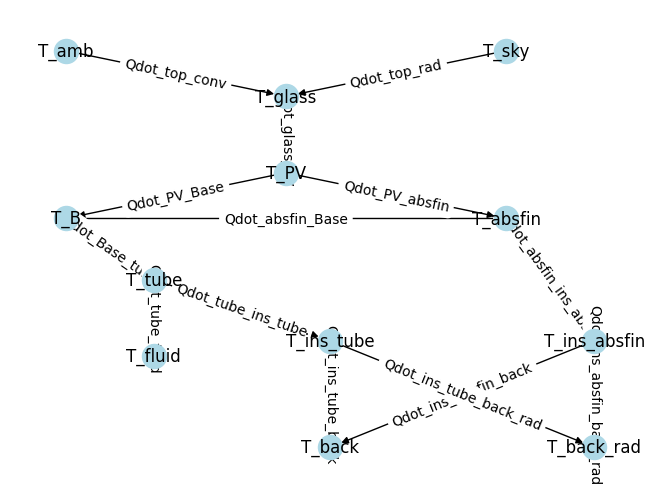

In [12]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes
nodes = ['T_amb', 'T_sky', 'T_glass', 'T_PV', 'T_B', 'T_absfin', 
         'T_tube', 'T_fluid', 'T_ins_absfin', 'T_ins_tube', 'T_back', 'T_back_rad']
G.add_nodes_from(nodes)

# Add edges with labels
edges = [('T_amb', 'T_glass', 'Qdot_top_conv'), ('T_sky', 'T_glass', 'Qdot_top_rad'),
         ('T_glass', 'T_PV', 'Qdot_glass_PV'), ('T_PV', 'T_B', 'Qdot_PV_Base'),
         ('T_PV', 'T_absfin', 'Qdot_PV_absfin'), ('T_absfin', 'T_B', 'Qdot_absfin_Base'),
         ('T_B', 'T_tube', 'Qdot_Base_tube'), ('T_tube', 'T_fluid', 'Qdot_tube_fluid'),
         ('T_absfin', 'T_ins_absfin', 'Qdot_absfin_ins_absfin'),
         ('T_tube', 'T_ins_tube', 'Qdot_tube_ins_tube'),
         ('T_ins_absfin', 'T_back', 'Qdot_ins_absfin_back'),
         ('T_ins_absfin', 'T_back_rad', 'Qdot_ins_absfin_back_rad'),
         ('T_ins_tube', 'T_back', 'Qdot_ins_tube_back'),
         ('T_ins_tube', 'T_back_rad', 'Qdot_ins_tube_back_rad')]

for u, v, label in edges:
    G.add_edge(u, v, label=label)

# Manually set positions based on TikZ coordinates
pos = {
    'T_amb': (3, 0),
    'T_sky': (8, 0),
    'T_glass': (5.5, -3),
    'T_PV': (5.5, -8),
    'T_B': (3, -11),
    'T_absfin': (8, -11),
    'T_tube': (4, -15),
    'T_fluid': (4, -20),
    'T_ins_absfin': (9, -19),
    'T_ins_tube': (6, -19),
    'T_back': (6, -26),
    'T_back_rad': (9, -26)
}

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='black')

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()


In [13]:
df_one.columns

Index(['G', 'Gp', 'T_amb', 'T_sky', 'T_back', 'T_back_rad', 'u', 'mdot',
       'T_fluid_in', 'h_rad_f', 'h_top_g', 'h_back', 'h_rad_back',
       'h_back_tube', 'h_rad_back_tube', 'h_back_fins', 'T_PV', 'T_fluid_out',
       'T_tube_mean', 'T_glass', 'h_fluid', 'h_rad', 'X_celltemp', 'eta_PV',
       'S', 'T_fluid_mean', 'T_Base_mean', 'T_absfin_mean', 'T_abs_mean',
       'Qdot_absfin_back', 'T_ins_tube_mean', 'T_ins_absfin_mean',
       'T_ins_mean', 'T_PV_Base_mean', 'T_PV_absfin_mean', 'Qdot_top_conv',
       'Qdot_top_rad', 'Qdot_sun_glass', 'Qdot_sun_PV', 'Qdot_glass_PV',
       'Qdot_PV_sky', 'Qdot_PV_plate', 'Qdot_PV_Base', 'Qdot_PV_absfin',
       'Qdot_Base_back', 'Qdot_tube_fluid', 'Qdot_tube_sky', 'Qdot_Base_tube',
       'Qdot_absfin_Base', 'Qdot_absfin_back_conv', 'Qdot_absfin_back_rad',
       'Qdot_tube_back_conv', 'Qdot_tube_back_rad', 'Qdot_ins_tube_back_conv',
       'Qdot_ins_tube_back_rad', 'Qdot_ins_absfin_back_conv',
       'Qdot_ins_absfin_back_rad', 'Qdot_f01'

In [14]:
df_one['T_back'].iloc[0]

281.15

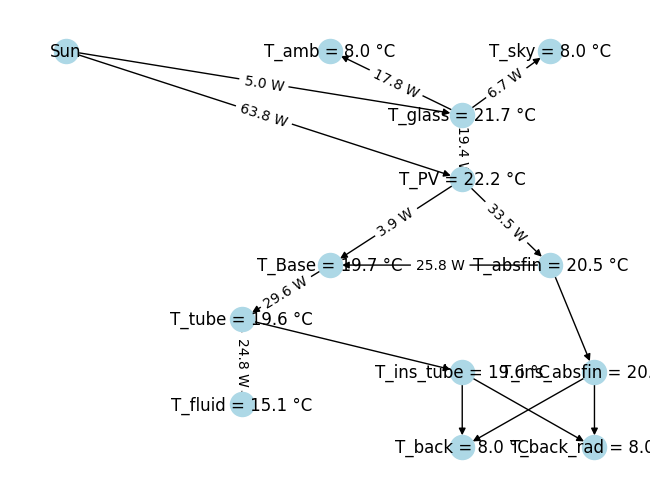

In [15]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes with labels including temperature
nodes = ['Sun','T_amb', 'T_sky', 'T_glass', 'T_PV', 'T_Base', 'T_absfin', 
         'T_tube', 'T_fluid', 'T_ins_absfin', 'T_ins_tube', 'T_back', 'T_back_rad']

nodes_keys = ['Sun','T_amb', 'T_sky', 'T_glass', 'T_PV', 'T_Base_mean', 'T_absfin_mean',
                'T_tube_mean', 'T_fluid_mean', 'T_ins_absfin_mean', 'T_ins_tube_mean', 'T_back', 'T_back_rad']

for i,node in enumerate(nodes):
    if node == "Sun":
        G.add_node(node, label=node)
    else:
        G.add_node(node, label=f"{node} = {round(df_one[nodes_keys[i]].iloc[0]-273.15,1)} °C")

# Add edges with heat transfer labels
edges = [('Sun','T_glass','Qdot_sun_glass'),('Sun','T_PV','Qdot_sun_PV'),
         ('T_glass', 'T_amb', 'Qdot_top_conv'),('T_glass', 'T_sky', 'Qdot_top_rad'),
         ('T_glass', 'T_PV', 'Qdot_glass_PV'), ('T_PV', 'T_Base', 'Qdot_PV_Base'),
         ('T_PV', 'T_absfin', 'Qdot_PV_absfin'), ('T_absfin', 'T_Base', 'Qdot_absfin_Base'),
         ('T_Base', 'T_tube', 'Qdot_Base_tube'), ('T_tube', 'T_fluid', 'Qdot_tube_fluid'),
         ('T_absfin', 'T_ins_absfin', ''),
         ('T_tube', 'T_ins_tube', ''),
         ('T_ins_absfin', 'T_back', ''),
         ('T_ins_absfin', 'T_back_rad', ''),
         ('T_ins_tube', 'T_back', ''),
         ('T_ins_tube', 'T_back_rad', '')]

for u, v, label in edges:
    if label == '':
        G.add_edge(u, v)
    else:
        G.add_edge(u, v, label=f"{round(df_one[label].iloc[0],1)} W")

# Manually set positions based on TikZ coordinates
pos = {'Sun': (3,0),
    'T_amb': (9, 0),
    'T_sky': (14, 0),
    'T_glass': (12, -6),
    'T_PV': (12, -12),
    'T_Base': (9, -20),
    'T_absfin': (14, -20),
    'T_tube': (7, -25),
    'T_fluid': (7, -33),
    'T_ins_absfin': (15, -30),
    'T_ins_tube': (12, -30),
    'T_back': (12, -37),
    'T_back_rad': (15, -37)
}

# Draw the graph with updated node labels
node_labels = nx.get_node_attributes(G, 'label')
nx.draw(G, pos, labels=node_labels, with_labels=True, node_color='lightblue', edge_color='black')

# Draw edge labels with updated heat transfer values
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

In [16]:
df_one['Qdot_sun_PV'] + df_one['Qdot_sun_glass']

0    68.83501
dtype: float64

In [17]:
- df_one['Qdot_top_conv'] - df_one['Qdot_top_rad'] - df_one['Qdot_PV_sky'] - df_one['Qdot_absfin_back_conv'] - df_one['Qdot_absfin_back_rad'] - df_one['Qdot_Base_back'] - df_one['Qdot_tube_back_conv'] - df_one['Qdot_tube_back_rad'] - df_one['Qdot_tube_sky']

0   -43.72037
dtype: float64

In [18]:
ht_labels = ['Qdot_sun_PV', 'Qdot_sun_glass', 'Qdot_top_conv', 'Qdot_top_rad', 'Qdot_PV_sky', 'Qdot_absfin_back_conv', 'Qdot_absfin_back_rad', 'Qdot_Base_back', 'Qdot_tube_back_conv', 'Qdot_tube_back_rad', 'Qdot_tube_sky']

In [19]:
ht_signs = {'Qdot_sun_PV':1, 'Qdot_sun_glass':1, 'Qdot_top_conv':-1, 'Qdot_top_rad':-1, 'Qdot_PV_sky':-1, 'Qdot_absfin_back_conv':-1, 'Qdot_absfin_back_rad':-1, 'Qdot_Base_back':-1, 'Qdot_tube_back_conv':-1, 'Qdot_tube_back_rad':-1, 'Qdot_tube_sky':-1}

In [20]:
df_one['Qdot_tube_fluid']

0    24.802458
Name: Qdot_tube_fluid, dtype: float64

In [21]:
data = {key:ht_signs[key]*df_one[key].values[0] for key in ht_labels}

In [22]:
# Adjusted approach for a single-column histogram with offset bars
fig = go.Figure()

# Initialize cumulative sums for positive and negative values
cumulative_positive = 0
cumulative_negative = 0

for key, value in data.items():
    if value >= 0:
        # For positive values, start from the last positive cumulative sum
        base = cumulative_positive
        cumulative_positive += value
    else:
        # For negative values, start from the last negative cumulative sum
        base = cumulative_negative
        cumulative_negative += value
    
    fig.add_trace(go.Bar(
        x=["Heat Transfer Contributions"],
        y=[value],
        name=key,
        width=0.2,
        base=base  # Set the starting point of the bar
    ))

# Update the layout
fig.update_layout(
    title="Decomposition of Qdot_tube_fluid in Different Heat Transfer Contributions",
    yaxis_title="Value",
    barmode="overlay"  # Overlay the bars
)

# Show the figure
fig.show()


In [ ]:
df_one['Q_PV_absfin']

In [ ]:
df_one['Q_absfin_Base']

In [ ]:
df_one['h_back']

In [ ]:
df_one['Q_absfin_back_rad'] 

In [ ]:
df_one['Q_absfin_back_conv']

In [ ]:
df_one['h_rad_back']

In [ ]:
df_one['T_absfin_mean']

In [ ]:
df_one['Q_Base_tube']

In [ ]:
df_one['Q_tube_fluid']

In [ ]:
df_one['Q_tube_back_conv']

In [ ]:
df_one['Q_tube_back_rad']

In [ ]:
df_one['Q_tube_sky']

In [ ]:
slices_df['T_tube_mean']

In [ ]:
slices_df['T_glass']

In [ ]:
slices_df['T_amb']

In [ ]:
df_one['Q_PV_Base']

In [ ]:
df_one['Q_absfin_Base'] 

In [ ]:
df_one['Q_Base_tube']

In [ ]:
df_one['Q_Base_back']

In [ ]:
df_one['Q_PV_Base'] + df_one['Q_Base_tube']

In [ ]:
df_one['T_PV']

In [ ]:
df_one['T_Base_mean']

In [ ]:
df_one['T_tube_mean']

In [ ]:
df_one['T_fluid_mean']

In [ ]:
6.09/9.84

In [ ]:
df_one['Q_tube_sky']

In [ ]:
df_one['Q_Base_tube']

In [ ]:
df_one['Q_tube_fluid']

In [ ]:
df_one['Q_tube_back_conv']

In [ ]:
df_one['Q_tube_back_rad']

In [ ]:
df_one['Q_glass_PV']

In [ ]:
df_one['Q_sun_glass']

In [ ]:
df_one['Q_top_conv']

In [ ]:
df_one['Q_top_rad']

In [ ]:
df_one['Q_PV_Base']

In [ ]:
df_one['Q_PV_absfin']

In [ ]:
df_one['Q_PV_plate']